In [8]:
!git clone https://github.com/claude9493/dsaa5002.git
!mv ./dsaa5002/dataset/ ./
!mv ./dsaa5002/util/ ./

fatal: destination path 'dsaa5002' already exists and is not an empty directory.


In [1]:
%%time

from utils.utils import create_dataset, Trainer
# from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))


Training on [cpu].
CPU times: user 1 s, sys: 361 ms, total: 1.37 s
Wall time: 1.28 s


In [2]:
%%time
SAMPLE_NUM = 10000
task = 'regression'  # 'classification'
dataset = create_dataset('movielens', sample_num=SAMPLE_NUM, task=task, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()


CPU times: user 13.2 ms, sys: 9.83 ms, total: 23.1 ms
Wall time: 122 ms


In [3]:
class CollaborativeFiltering(nn.Module):
    
    def __init__(self, field_dims, embed_dim=4):
        super(CollaborativeFiltering, self).__init__()
        n_users, n_movies = field_dims[0], field_dims[1]
        self.u = nn.Embedding(n_users, embed_dim)
        self.m = nn.Embedding(n_movies, embed_dim)
        self.u.weight.data.uniform_(0, 0.05)
        self.m.weight.data.uniform_(0, 0.05)

        
    def forward(self, x):
        users, movies = x[:,0], x[:,1]
        u, m = self.u(users), self.m(movies)
        return (u*m).sum(1).view(-1, 1)

100%|██████████| 500/500 [01:14<00:00,  6.73it/s]


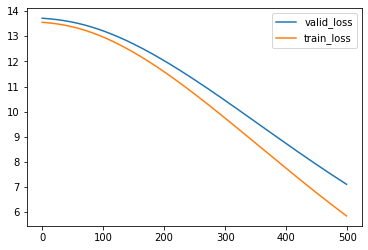

train_loss: 5.84570 | train_metric: -5.84570
valid_loss: 7.11292 | valid_metric: -7.11292
test_loss:  7.28699 | test_metric:  -7.28699
CPU times: user 1min 11s, sys: 2.52 s, total: 1min 14s
Wall time: 1min 14s


In [4]:
%%time

EMBEDDING_DIM = 8
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 1024
EPOCH = 500
TRIAL = 100

cf = CollaborativeFiltering(field_dims, EMBEDDING_DIM).to(device)
optimizer = optim.Adam(cf.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
# criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

trainer = Trainer(cf, optimizer, criterion, BATCH_SIZE, task=task)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_metric = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_metric:  {:.5f}'.format(test_loss, test_metric))
